## Introduction

A particle's energy can be broken into different types of energy, such as kinetic or potential energy. Further, in physics there is a concept known as a potential well, wherein an area of space with little or no potential "height" is bounded by areas of significantly higher potential energy.

<img src="files/Potential Energy Well.png">

The above case is a 1D potential energy well, where the particle can "roll" left and right, trading its kinetic energy for potential as it "climbs" the slopes. Once it runs out of kinetic energy, it starts to move back towards the center, converting its potential to kinetic energy. Higher kinetic energy particles can move further up the well, while lower energy ones are trapped lower in the well. In this instance, the amount of potential is a function based on distance that eventually levels off, meaning a particle could theoretically escape the well.

For the purposes of this workbook, we have a particle that is inside a spherical potential well. Like the 1D potential well, it has areas of higher and lower potential. In particular, inside the sphere has no potential, meaning the particle is free to move, while a particle outside the sphere experiences a constant force towards the center of the sphere. Because the force is independent of the distance outside the radius, it means that no particle can truly escape the well, as it will always experience a force towards the centre of the sphere.

This model can be described by the equations:

$$U(r) = -U_0$$

$$U(r) = 0$$

where $U_0$ is a positive constant.

As the particle begins to move in the outside region, the potential well exerts a force on it, resulting in the generation of work. Using the kinematic equations, it can be shown that:
$$F = ma$$
$$V_f = V_i + at$$
and thus:
$$V_f = V_i + \frac{Ft}{m}$$

Given information about the particle's initial velocity and mass, the final velocity can be generated at any point, since it experiences no acceleration inside the sphere (and thus between any two points inside the sphere, velocity is the same). As the particle moves up the well, it experiences a force, and travels a distance, which generates work. Thus, one can calculate its final velocity after the motion. By iterating this through time steps, the particle's motion can be mapped through the 3D space.

## Numerical Model

In order to both effectively and quickly map the motion of the particle, the program will use a step-by-step model. The program does not calculate the position based on an overall equation that perfectly models motion, but rather individual steps. Given a time span from $t_i$ to $t_f$, it can be subdivided into a user-specified number of N steps.
$$h=(t_f - t_i)/N$$

At any point, the particle also has a velocity and position, given by 3-space vectors (such that $V = [V_x,V_y,V_z]$ and similar for the position vector). Once again, referring to the kinematic equations, motion through space can be modelled as:
$$Position_f = Position_i + Velocity*Time$$
which in this case is:
$$Position_{nf} = Position_{ni} + Velocity_n * h$$

Each position and velocity value is generated in sequence and added to a list of values, recording the particle's behaviour from the given times in steps of $h$. However, without any further functions, the particle would just head off in one direction and never stop. The key here is the constant force directed radially inwards. In each time step, the particle undergoes an acceleration, which brings it back towards the center of the sphere. Knowing the force on the particle, as well as its mass, yields the acceleration. Using basic kinematics, the final velocity at any step can be determined. The accuracy of this estimation is based on the number of steps chosen, with more steps being more precise, but more time consuming.

## Code

In [1]:
# Import block
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
%matplotlib inline

In [23]:
# Function definitions

def potential_Restriction(U_test = False):
    '''Restricts the possible values of potential to purely positive values, as defined in the problem set up.
    The "U_test" option defaults to a set value to make testing easy.
    
    returns: The force outside the radius
    '''
    
    passing = False
    if (U_test == True):
        return 5
    else:
        while(passing == False):
            U = int(input("Please enter a positive value of potential energy in Joules: "))
            if (U > 0):
                passing = True
            else:
                passing = False
    return U


def well_check (position, radius):
    '''Checks to see if the particle is in the well
    
    Arguments:
    position: The current position of the particle in 3D space
    radius: The radius of the spherical potential well
    
    returns: True if within radius, False otherwise
    '''
    
    # Calculate magnitude of position vector
    magnitude = 0
    for p in position:
        magnitude += p**2
    magnitude = magnitude ** 0.5
    
    # Compare against magnitude of radius
    if (magnitude < radius):
        return True
    else:
        return False
    
    

def force_calc (position, radius, force):
    '''Calculates the force vector based on current position
    
    Arguments:
    position: a three part vector indicating the x,y,z components of the particle's current position
    radius: a constant value of the radius of the spherical potential well
    force: the value of force outside the potential well
    
    returns: Force as a 3-space vector
    '''
    
    sum = 0
    impulse = []
    
    # Calculate the magnitude of the position vector
    for i in range(3): #Note, this is because it is being performed in 3D space
        sum += (position[i]**2)
    sum = sum**0.5
    
    # Create radial force vector from unit position vector
    if (sum > radius):
        for i in range(len(position)):
            position[i] = position[i]/sum
            impulse.append(-1 * (position[i]) * force)
        return impulse
    
    else:
        return [0,0,0]
    

def new_position (position, velocity, timestep):
    '''Generates the next position as well as the displacement vector
    
    Arguments:
    position: The particle's current position
    velocity: The particle's current velocity
    timestep: The discrete time the motion occurs over
    
    returns: New position coordinates or displacement
    '''
    
    Position2 = [] # New position vector
    displacement = [] # Displacement vector
    for i in range(len(position)):
        Position2.append(position[i] + velocity[i] * timestep)
        displacement.append(Position2[i]-position[i])
        
    return Position2, displacement


def velocity_change (velocity, force, mass, timestep):
    '''Uses kinematic equations to calculate change in velocity
    
    Arguments:
    velocity: current velocity of particle at beginning of time step; 3-space vector
    force: the force on the particle; 3-space vector
    mass: mass of the particle
    
    returns: new velocity as 3-space vector
    '''
    
    new_velocity = []
    acceleration = []
    
    # Generate axial accelerations
    for f in range(len(force)):
        acceleration.append(force[f] / timestep)
    
    # Generate new velocity using kinemati equations
    for v in range(len(velocity)):
        new_velocity.append(velocity[v] + acceleration[v] * timestep)
    
    return new_velocity


def potential_well (position, velocity, mass, radius, steps, iTime, fTime):
    '''Makes the whole run-time into a function so it can be called multiple times in minimal space
    
    Arguments:
    position: starting position of the particle
    velocity: starting velocity of the particle
    mass: mass of the particle
    radius: the radius of the spherical potential well
    steps: number of steps to take
    iTime: starting time
    fTime: ending time
    
    returns:
    positions: a list of positions the particle has been at over the timespan
    velocities: a list of velocities the particel has been travelling at
    times: times paired to the above values
    '''
    
    # Initialization of the lists
    positions = []
    velocities = []
    times = []
    positions.append(position)
    velocities.append(velocity)
    times.append(iTime)
    
    # Generation of time step
    time_step = (fTime-iTime)/steps
    
    # Get the value of potential from the user
    potential = potential_Restriction(U_test = False)
    
    count = 0
    while (count < steps):
        # Both calculations need new positions
        new_location, displacement = new_position(positions[count], velocities[count], time_step)
        positions.append(new_location)
        
        if (well_check(positions[count], radius) == True):
            # Keep old velocity, since it did not change
            velocities.append(velocities[count])
            
        else:
            # Calculate force and work based on old position and displacement
            force = force_calc(positions[count], radius, potential)
            
            # Calculate new velocity based on work done
            new_velocity = velocity_change(velocities[count], force, mass, time_step)
            
            # Add new position and velocity, as well as time
            velocities.append(new_velocity)
        
        # Append new time (note: independent of inside/outside well)
        times.append(iTime+(count+1)*time_step)
        
        # Increase count
        count+=1
    return positions, velocities, times

In [37]:
# Constant block
R = 1                                      # Defines the length of the radius
Velocity = [0,0,1]                         # Defines the initial velocity of the particle
initial_position = [0,0,0]                 # Defines the starting position of the particle
mass = 1000                                # Defines mass of particle; default uses proton for sampling
    
# Time and steps block
t_0 = 0                                    # Starting time
t_final = 4                                # End time
steps = 100000                               # Number of steps in time; increase for more precision

# Test case
positions, velocities, times = potential_well (initial_position, Velocity, mass, R, steps, t_0, t_final)

# Remove last, extreme value
positions = positions[0:steps]
velocities = velocities[0:steps]
times = times[0:steps]

Please enter a positive value of potential energy in Joules: 10


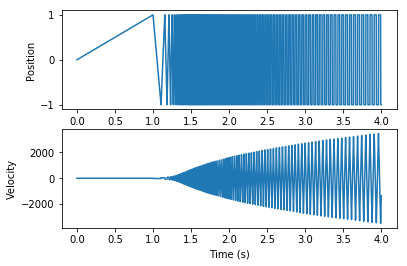

In [38]:
# Obtain only one set of coordinates at a time
x_coords = []
y_coords = []
z_coords = []
xv_coords = []
yv_coords = []
zv_coords = []

for i in range(len(positions)):
    x_coords.append(positions[i][0])
    y_coords.append(positions[i][1])
    z_coords.append(positions[i][2])
    xv_coords.append(velocities[i][0])
    yv_coords.append(velocities[i][1])
    zv_coords.append(velocities[i][2])

plt.subplot(2,1,1)
plt.plot(times,z_coords)
plt.xlabel("Time (s)")
plt.ylabel("Position")

plt.subplot(2,1,2)
plt.plot(times,zv_coords)
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.show()